# Comparing effects between GWAS and mQTL
Plan:
1. Gather colocalized SNP for each GWAS
1. Gather GWAS effects
1. Gather mQTL effects from each set
1. Run correlations
1. Add plot to supplementary figure etc.

In [1]:
library(data.table)
library(tidyverse)
library(corrplot)
library(parallel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Warning message:
“package ‘corrplot’ was built under R version 4.1.1”
corrplot 0.92 loaded



In [2]:
tmp <- fread("../../data/colocalization_by_probe.csv")
head(tmp)
unique(tmp$mQTL)
unique(tmp$GWAS)

mQTL,GWAS,hits,probe
<chr>,<chr>,<int>,<chr>
male-stratified,Type 1 Diabetes,16,"cg08373989,cg18067840,cg18060330,cg16711450,cg06793162,cg03807391,cg17543112,cg26958806,cg13740929,cg23634079,cg13907973,cg25317746,cg00022997,cg23739027,cg25769566,cg14945317"
"cross-sex,male-stratified",Birth Weight,46,"cg26921638,cg02991924,cg13996003,cg19242610,cg11876048,cg18405544,cg02527881,cg06330618,cg07822788,cg10780367,cg02156692,cg25317746,cg15448385,cg08267399,cg17265693,cg00893242,cg01287833,cg16095155,cg21062891,cg12288758,cg23998635,cg00100420,cg03316587,cg20992439,cg25256661,cg08886154,cg01176363,cg13318129,cg09444226,cg07235057,cg03780997,cg20962215,cg26658897,cg21161526,cg08672140,cg17030679,cg05840412,cg24583287,cg07278158,cg21334609,cg15374898,cg04898211,cg27191651,cg01086672,cg01793865,cg20645601"
"cross-sex,female-stratified",Pubertal Growth Start,1,cg00106432
female-stratified,Type 1 Diabetes,17,"cg17018201,cg06937619,cg00970279,cg16237409,cg19372359,cg25191172,cg12297501,cg00274587,cg09803951,cg11318895,cg18700744,cg05488160,cg17240976,cg04414917,cg02353427,cg00169019,cg03598801"
"cross-sex,female-stratified,male-stratified",Birth Weight,53,"cg09369927,cg13302670,cg05867245,cg17343385,cg03437748,cg00200653,cg07078329,cg15988812,cg25647583,cg26899598,cg05180856,cg04607235,cg14183927,cg23762465,cg11539674,cg07684647,cg07094194,cg00628211,cg03130962,cg20229609,cg16519772,cg00688979,cg06652085,cg05522349,cg06653140,cg07686394,cg25457927,cg06106103,cg12044213,cg02652369,cg21497082,cg27092297,cg00698126,cg26512045,cg07679836,cg24505687,cg02226672,cg07878625,cg14660024,cg09626299,cg00277334,cg09077675,cg04676934,cg01140214,cg07304760,cg02247838,cg12748446,cg11569329,cg11667387,cg04506342,cg02004401,cg10991855,cg09009770"
"cross-sex,female-stratified,male-stratified",CUD,2,"cg00204512,cg05966235"


[1] "male-stratified"                            
[2] "cross-sex,male-stratified"                  
[3] "cross-sex,female-stratified"                
[4] "female-stratified"                          
[5] "cross-sex,female-stratified,male-stratified"
[6] "cross-sex"                                  
[7] "female-stratified,male-stratified"

[1] "Type 1 Diabetes"        "Birth Weight"           "Pubertal Growth Start" 
 [4] "CUD"                    "SCZ"                    "Child Onset Asthma"    
 [7] "AN"                     "Hayfever or Eczema Age" "Child BMI"             
[10] "Child Obesity"          "Late Pubertal Growth"   "ADHD"

In [3]:
fwrite(data.table(probe=Reduce(c,strsplit(tmp[grepl("cross",mQTL)]$probe,","))),"../../data/cross-colocalized-probes.csv")
fwrite(data.table(probe=Reduce(c,strsplit(tmp[mQTL == "female-stratified,male-stratified"]$probe,","))),"../../data/male-female-colocalized-probes.csv")
fwrite(data.table(probe=Reduce(c,strsplit(tmp[mQTL == "male-stratified"]$probe,","))),"../../data/male-colocalized-probes.csv")
fwrite(data.table(probe=Reduce(c,strsplit(tmp[mQTL == "female-stratified"]$probe,","))),"../../data/female-colocalized-probes.csv")

## GWAS Effects

In [3]:
gwas_list <- c(
    "Child Obesity"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_Obesity_Meta_Analysis_1.txt.sumstats.gz",
    "Late Pubertal Growth"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PTF_PTM_combined.txt.sumstats.gz",
    "Child BMI"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_BMI_HapMap_DISCOVERY.txt.sumstats.gz",
    "Pubertal Growth Start"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_10F_12M_combined.txt.sumstats.gz",
    "Child Onset Asthma"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC.sumstats.gz",
    "Type 1 Diabetes"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/T1D.UCSC_META.sumstats.gz",
    "Hayfever or Eczema Age"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/hayfever_eczema_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "Birth Weight"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Fetal_BW_European_meta.NG2019.txt.sumstats.gz",
    "ADHD"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",
    "AN"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgcAN2.2019-07.vcf.tsv.sumstats.gz",
    "CUD"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/Cannabis_ICC_23andmetop_UKB_het.txt.sumstats.gz",
    "SCZ"="/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC3_SCZ_wave3_public.v2.tsv.sumstats.gz"
)
gwas_effects <- rbindlist(mclapply(gwas_list,fread,mc.cores=12),use.names=TRUE,idcol="GWAS")

In [4]:
head(gwas_effects)

GWAS,SNP,A1,A2,Z,N
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Child Obesity,rs3094315,A,G,-0.071,13848
Child Obesity,rs3131968,A,G,0.065,13848
Child Obesity,rs2905035,A,G,0.181,13848
Child Obesity,rs4040617,A,G,-0.147,13848
Child Obesity,rs2905062,A,G,-0.930,13848
Child Obesity,rs2980300,T,C,-0.172,13848


In [5]:
male_mqtl < -fread("../../data/male-all-colocalized.txt")
female_mqtl < -fread("../../data/female-all-colocalized.txt")
cross_mqtl < -fread("../../data/cross-all-colocalized.txt")

In [6]:
male_cor <- male_mqtl[,.SD[which.min(p)],by="Probe"][gwas_effects,on="SNP",nomatch=0] %>% 
    mutate(Z_mqtl = ifelse(A1 == i.A2 & A2 == i.A1, -b/SE,ifelse(A1 == i.A1 & A2 == i.A2, b /SE,NA)))
female_cor <- female_mqtl[,.SD[which.min(p)],by="Probe"][gwas_effects,on="SNP",nomatch=0] %>% 
    mutate(Z_mqtl = ifelse(A1 == i.A2 & A2 == i.A1, -b/SE,ifelse(A1 == i.A1 & A2 == i.A2, b /SE,NA)))
cross_cor <- cross_mqtl[,.SD[which.min(p)],by="Probe"][gwas_effects,on="SNP",nomatch=0] %>% 
    mutate(Z_mqtl = ifelse(A1 == i.A2 & A2 == i.A1, -b/SE,ifelse(A1 == i.A1 & A2 == i.A2, b /SE,NA)))

In [7]:
suppressWarnings(male_cor_table <- male_cor %>% 
    group_by(GWAS) %>%
    summarize(
        Set= "Male-specific",
        rho=cor.test(Z_mqtl,Z,method="spearman")$estimate,
        p=cor.test(Z_mqtl,Z,method="spearman")$p.value
    ))
suppressWarnings(female_cor_table <- female_cor %>% 
    group_by(GWAS) %>%
    summarize(
        Set= "Female-specific",
        rho=cor.test(Z_mqtl,Z,method="spearman")$estimate,
        p=cor.test(Z_mqtl,Z,method="spearman")$p.value
    ))
suppressWarnings(cross_cor_table <- cross_cor %>% 
    group_by(GWAS) %>%
    summarize(
        Set= "Cross-sex",
        rho=cor.test(Z_mqtl,Z,method="spearman")$estimate,
        p=cor.test(Z_mqtl,Z,method="spearman")$p.value
    ))

In [8]:
gwas_order <- c(
    "ADHD",
    "SCZ",
    "AN",
    "CUD",
    "Child Onset Asthma",
    "Hayfever or Eczema Age",
    "Type 1 Diabetes",
    "Birth Weight",
    "Child BMI",
    "Child Obesity",
    "Pubertal Growth Start",
    "Late Pubertal Growth"
)
rho_mat <- rbind(cross_cor_table,male_cor_table,female_cor_table) %>%
    select(-p) %>%
    pivot_wider(names_from="GWAS",values_from="rho") %>%
    column_to_rownames("Set") %>% 
    as.matrix()
p_mat <- rbind(cross_cor_table,male_cor_table,female_cor_table) %>% 
    select(-rho) %>% 
    pivot_wider(names_from="GWAS",values_from="p") %>%
    column_to_rownames("Set") %>% 
    as.matrix()

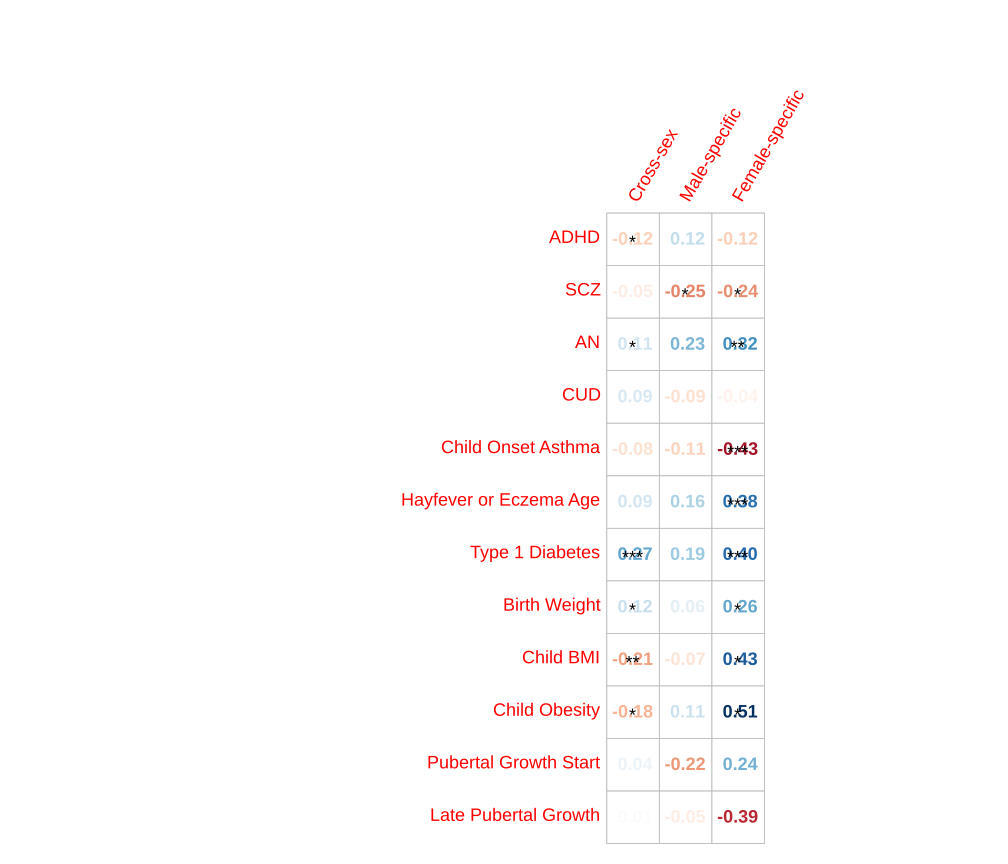

In [10]:
library(repr)
options(repr.plot.width = 14,repr.plot.height=12,jupyter.plot_mimetypes = "image/svg+xml")
corrplot(
    t(rho_mat[,gwas_order]),
    p.mat=t(p_mat[,gwas_order]),
    method = "number",
    insig = 'label_sig',
    pch.cex = 1.5,
    pch.col="black",
    is.corr=FALSE,
    tl.cex=1.5,
    tl.srt=60,
    number.cex=1.5,
    cl.cex=1.2,
    cl.pos="n",
    sig.level=c(0.001,0.01,0.05)
)